Epoch 1: Train Loss: 1.031153651744854, Train Accuracy: 53.1810766721044, Val Loss: 1.235227506434811, Val Accuracy: 51.42857142857143
Epoch 2: Train Loss: 0.8425303890937712, Train Accuracy: 65.41598694942904, Val Loss: 0.9909620349783272, Val Accuracy: 60.317460317460316
Epoch 3: Train Loss: 0.69167739040241, Train Accuracy: 73.4094616639478, Val Loss: 0.8127252517534154, Val Accuracy: 64.44444444444444
Epoch 4: Train Loss: 0.5755644193055426, Train Accuracy: 79.44535073409462, Val Loss: 0.6326563370547125, Val Accuracy: 77.46031746031746
Epoch 5: Train Loss: 0.4795860688679102, Train Accuracy: 83.19738988580751, Val Loss: 0.7596778207746823, Val Accuracy: 72.06349206349206
Epoch 6: Train Loss: 0.5528455328287147, Train Accuracy: 82.54486133768353, Val Loss: 0.9103177525324836, Val Accuracy: 64.12698412698413
Epoch 7: Train Loss: 0.3967800698810961, Train Accuracy: 85.15497553017944, Val Loss: 0.7721204331804378, Val Accuracy: 75.23809523809524
Epoch 8: Train Loss: 0.4005876579208345

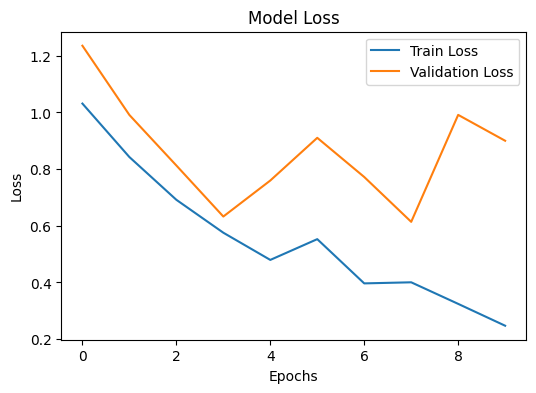

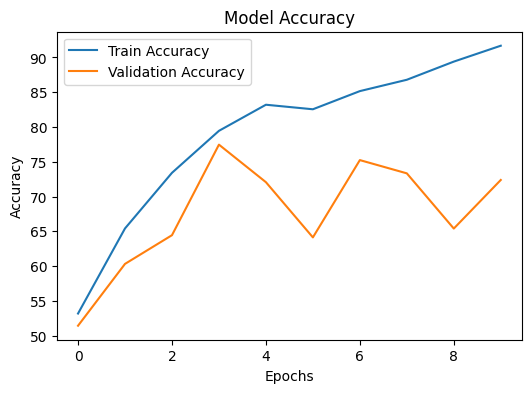

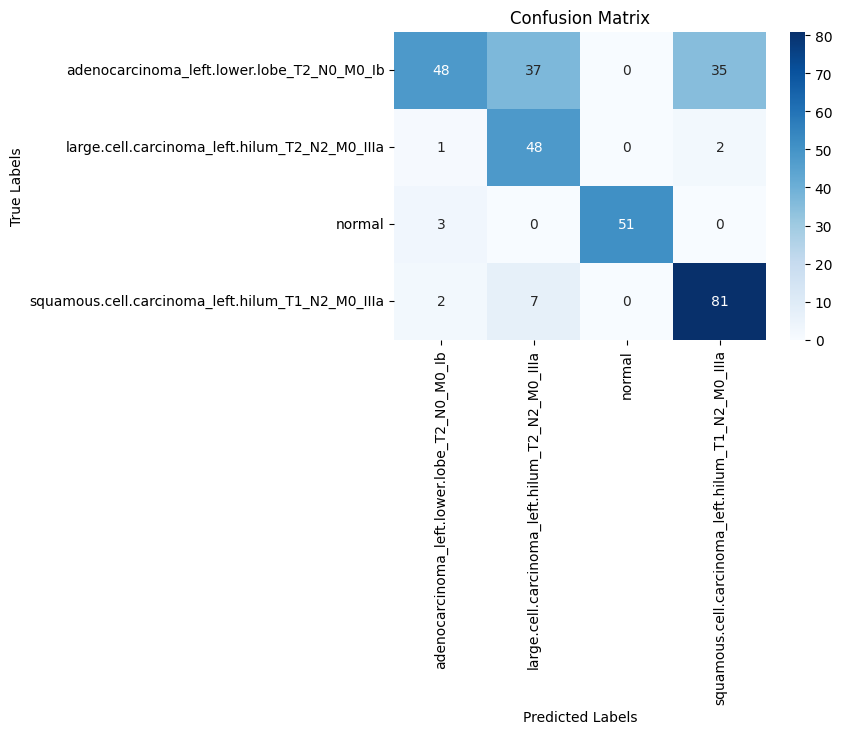

In [7]:
import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Transformations
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Datasets
train_dataset = datasets.ImageFolder('./archive/Data/train', transform=train_transform)
test_dataset = datasets.ImageFolder('./archive/Data/test', transform=test_transform)

# Loaders
train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False)

# Model setup
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 4)
)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Early Stopping setup
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Training and validation function
def train_and_validate(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    early_stopper = EarlyStopping(patience=3, min_delta=0.01)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        train_accuracies.append(train_accuracy)
        train_losses.append(running_loss / len(train_loader))

        val_loss, val_accuracy, _, _ = validate(model, test_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}: Train Loss: {train_losses[-1]}, Train Accuracy: {train_accuracies[-1]}, Val Loss: {val_losses[-1]}, Val Accuracy: {val_accuracies[-1]}")

        if early_stopper(val_loss):
            print("Early stopping triggered.")
            break

    return train_losses, val_losses, train_accuracies, val_accuracies

# Validation function
def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    average_loss = total_loss / len(loader)
    accuracy = 100 * correct / total
    return average_loss, accuracy, all_preds, all_labels

# Plotting function
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, all_preds, all_labels):
    class_labels = [label.split('.')[0] for label in train_dataset.classes]
    
    # Plotting Model Loss
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plotting Model Accuracy
    plt.figure(figsize=(6, 4))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plotting Confusion Matrix
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Run training and evaluation
train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=10)
val_loss, val_accuracy, all_preds, all_labels = validate(model, test_loader, criterion)
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, all_preds, all_labels)
